In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/Proj_FRCNN')

In [3]:

from Data_class import Custom_Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [ ]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

if __name__ == "__main__":
    # use our dataset and defined transformations
    dataset = Custom_Dataset('Gun_300/train', "gun_train_update_annot.json", get_transform(train=True))
    dataset_test = Custom_Dataset('Gun_300/val', "Gun_val_annot_update.json", get_transform(train=False))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and beagle
    num_classes = 2

    # get the model using our helper function
    model = build_model(num_classes)
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # number of epochs
    num_epochs = 20
    #start training
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    # save trained model for inference
    torch.save(model, './output/Gun-Detection-300.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

Epoch: [0]  [  0/124]  eta: 0:11:01  lr: 0.000046  loss: 0.8466 (0.8466)  loss_classifier: 0.6628 (0.6628)  loss_box_reg: 0.1655 (0.1655)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0116 (0.0116)  time: 5.3383  data: 1.8519  max mem: 2582
Epoch: [0]  [ 10/124]  eta: 0:01:45  lr: 0.000452  loss: 0.6228 (0.6086)  loss_classifier: 0.5010 (0.4728)  loss_box_reg: 0.0905 (0.0910)  loss_objectness: 0.0313 (0.0383)  loss_rpn_box_reg: 0.0047 (0.0065)  time: 0.9248  data: 0.1777  max mem: 2736
Epoch: [0]  [ 20/124]  eta: 0:01:17  lr: 0.000858  loss: 0.3067 (0.4545)  loss_classifier: 0.1744 (0.3202)  loss_box_reg: 0.0909 (0.0985)  loss_objectness: 0.0245 (0.0294)  loss_rpn_box_reg: 0.0046 (0.0064)  time: 0.5151  data: 0.0119  max mem: 2739
Epoch: [0]  [ 30/124]  eta: 0:01:02  lr: 0.001264  loss: 0.3001 (0.4083)  loss_classifier: 0.1592 (0.2731)  loss_box_reg: 0.1127 (0.1053)  loss_objectness: 0.0150 (0.0243)  loss_rpn_box_reg: 0.0039 (0.0056)  time: 0.5261  data: 0.0111  max mem: 2739


Max_Pred_Confidence :  0.99215937
[0.99215937, 0.9734447] ['Gun', 'Gun']


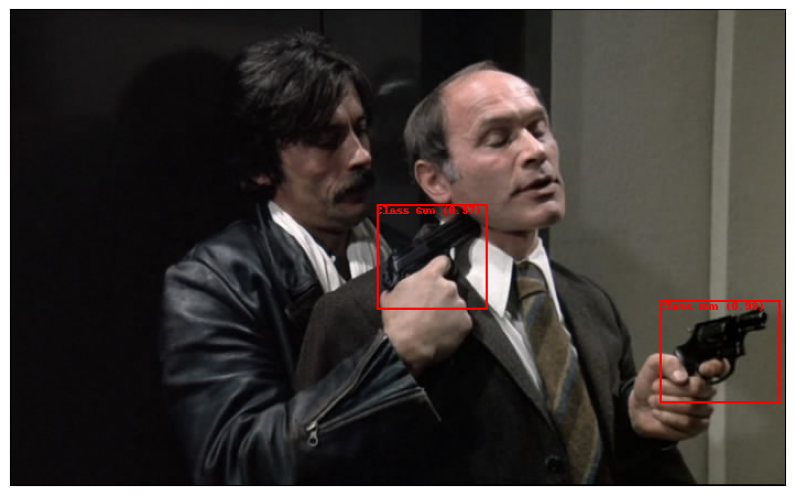

In [4]:
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random


CLASS_NAMES = ["__background__", "Gun"]
def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold value for prediction score
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - class, box coordinates are obtained, but only prediction score > threshold
          are chosen.

    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img).to(device)
    pred = model([img])
    # print(pred)
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    # print("pred_boxes: ",pred_boxes,", Pred class: ", pred_class)
    # [[(47.635437, 116.58713), (77.86283, 151.456)], [(35.182247, 40.40342), (68.013054, 62.37248)]]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    print("Max_Pred_Confidence : ", pred_score[0])
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    # print(pred_t)

    pred_boxes = pred_boxes[:pred_t+1]
    # print(pred_boxes)
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

def draw_boxes_on_image(image, predictions, threshold=0.5):
    # Create a copy of the image to draw on
    drawn_image = image.copy()
    # Create a draw object
    draw = ImageDraw.Draw(drawn_image)
    # Define a transform to convert PyTorch tensors to PIL images
    transform = T.ToPILImage()

    # Iterate through each prediction
    for score, label, box in zip(predictions['scores'], predictions['labels'], predictions['boxes']):

        # Draw bounding box
        draw.rectangle(box, outline="red", width=2)
        # Get the label name (replace with your own label mapping if needed)
        label_name = f"Class {label}"
        # Draw text with label and score
        draw.text((box[0], box[1]), f"{label_name} ({score:.2f})", fill="red")

    return drawn_image

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=1):
    """
    object_detection_api
      parameters:
        - img_path - path of the input image
        - confidence - threshold value for prediction score
        - rect_th - thickness of bounding box
        - text_size - size of the class label text
        - text_th - thichness of the text
      method:
        - prediction is obtained from get_prediction method
        - for each prediction, bounding box is drawn and text is written
          with opencv
        - the final image is displayed
    """
    boxes, pred_cls, pred_score = get_prediction(img_path, confidence)
    # flattened_coordinates = [int(coord) for point in boxes[0] for coord in point]
    flattened_coordinates = [[int(coord) for point in box for coord in point] for box in boxes]
    preds = {"scores" : pred_score, "labels" : pred_cls, "boxes" : flattened_coordinates}
    print(pred_score, pred_cls)
    # print(len(boxes))

    val_image = Image.open(img_path)
    img = draw_boxes_on_image(val_image, preds, threshold=confidence)

    plt.figure(figsize=(10,15))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

if __name__ == "__main__":
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # model = torch.load(args["model"])
    model = torch.load('./output/Gun-Detection-300.pt')
    # img_path = args["image"]
    img_path = "./Gun_300/val/Img293.jpg"
    # detect_object(img_path, confidence=args["confidence"])
    detect_object(img_path, confidence=0.5)


In [5]:

 files = os.listdir("./Gun_300/val/")

# Filter only image files (you may customize this based on your image file extensions)
image_files = [file for file in files if file.lower().endswith(( '.jpeg', '.JPG', '.jpg', '.png'))]

for i, im_pth in enumerate(image_files):
  print(im_pth)

  if i > 4:
    break

  try:
    detect_object(f"./Gun_300/val/{im_pth}", confidence=0.5)

  except IndexError:
      print(f"IndexError at index {im_pth}, skipping this iteration.")
      continue



Output hidden; open in https://colab.research.google.com to view.